In [2]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_smooth/'
save_path=BASE+"trained_models"

import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
#import util.metrics as metrics
#import util.misc as misc
#import pyqg_explorer.dataset.forcing_dataset as forcing_dataset


In [3]:
input_list = ['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain']

In [4]:
# TRAIN AND TEST ONLY
# randomnly generate train, test and validation time indecies 
import random
time_ind = 8450#X_input_strain.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 123#14
random.Random(rand_seed).shuffle(rand_ind)
train_percent = 0.9
test_percent = 0.1 
print(f"Dataset: train {np.round(train_percent*100)}%, test {np.round(test_percent*100)}%")
train_ind, test_ind =  rand_ind[:round(train_percent*time_ind)], rand_ind[round((train_percent)*time_ind):]                                                                        

# sort test_ind
test_ind = np.sort(test_ind)

# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')

Dataset: train 90.0%, test 10.0%
no overlapping indecies


In [5]:
# Y OUTPUT
WB_sg = np.load(PATH_NN+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN+'WB_sg_std.npy')
              
Y_output = np.tile(WB_sg,(1,1,1,1)).reshape(WB_sg.shape[0],1,WB_sg.shape[1],WB_sg.shape[2]) 
print('Y output shape:')
print(Y_output.shape)
print('')


Y output shape:
(8450, 1, 40, 40)



In [6]:
drF = np.load(PATH_NN+'drF.npy')
WB_FK = np.load(PATH_NN+'WB_FK.npy')
Lf_BD23 = np.load(PATH_NN+'Lf_BD23.npy')
Lf_FK11 = np.load(PATH_NN+'Lf_FK11.npy')

In [7]:
# renormalize using mean and std 
# SORT test_ind for timeseries
WB_sg_mean_test = WB_sg_mean[test_ind]
WB_sg_std_test = WB_sg_std[test_ind] 


mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_sg = np.squeeze(xr.DataArray(Y_output[test_ind]*std_tile + mean_tile))

In [8]:
# X INPUT
grad_B = np.load(PATH_NN+'grad_B.npy')
FCOR = np.load(PATH_NN+'FCOR.npy')
Nsquared = np.load(PATH_NN+'Nsquared.npy')
HML = np.load(PATH_NN+'HML.npy')
TAU = np.load(PATH_NN+'TAU.npy')
Q = np.load(PATH_NN+'Q.npy')
HBL = np.load(PATH_NN+'HBL.npy')
div = np.load(PATH_NN+'div.npy')
vort = np.load(PATH_NN+'vort.npy')
strain = np.load(PATH_NN+'strain.npy')


## load trained nn + input channels for each feature test
feature = input_list[0]
save_name_m_grad_B='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_grad_B)
X_input = np.stack([FCOR, HML, Nsquared, TAU, Q, HBL, div, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_grad_B = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[1]
save_name_m_FCOR='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_FCOR)
X_input = np.stack([grad_B, HML, Nsquared, TAU, Q, HBL, div, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_FCOR = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[2]
save_name_m_Nsquared='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_Nsquared)
X_input = np.stack([grad_B, HML, FCOR, TAU, Q, HBL, div, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_Nsquared = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[3]
save_name_m_HML='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_HML)
X_input = np.stack([FCOR, grad_B, Nsquared, TAU, Q, HBL, div, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_HML = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[4]
save_name_m_TAU='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_TAU)
X_input = np.stack([FCOR, grad_B, Nsquared, HML, Q, HBL, div, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_TAU = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[5]
save_name_m_Q='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_Q)
X_input = np.stack([FCOR, grad_B, Nsquared, HML, TAU, HBL, div, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_Q = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[6]
save_name_m_HBL='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_HBL)
X_input = np.stack([FCOR, grad_B, Nsquared, HML, TAU, Q, div, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_HBL = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[7]
save_name_m_div='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_div)
X_input = np.stack([FCOR, grad_B, Nsquared, HML, TAU, Q, HBL, vort, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_div = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[8]
save_name_m_vort='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_vort)
X_input = np.stack([FCOR, grad_B, Nsquared, HML, TAU, Q, HBL, div, vort],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_vort = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

feature = input_list[9]
save_name_m_strain='fcnn_k3_l3_select_m_'+feature+'.pt'
model = torch.load(save_path+'/'+save_name_m_strain)
X_input = np.stack([FCOR, grad_B, Nsquared, HML, TAU, Q, HBL, div, strain],axis=1)
pred = model(torch.from_numpy(X_input[test_ind]).float())
WB_cnn_strain = np.squeeze(xr.DataArray((pred).detach().cpu().numpy()*std_tile + mean_tile))
del model, X_input, pred

KeyboardInterrupt: 

# Dataloader

### Create input and output channels

In [3]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [ ]:
PATH_LIST_full

In [ ]:
label_list = ['Bengal','Agulhas', 'New Zealand', 'North Pacific', 'Equatorial Atlantic',
              'Gulf', 'South Atlantic', 'Argentina', 'Australia', 'Indian Ocean']

# prediction timeseries

In [ ]:
WB_sg_mean_test_loc = np.empty((10))
WB_sg_mean_test_loc[:] = np.nan
WB_sg_std_test_loc = np.empty((10))
WB_sg_std_test_loc[:] = np.nan

# cell size 
drF_test = drF[test_ind] 
drF_test_loc = np.empty((10,845,40,40))
drF_test_loc[:] = np.nan


WB_cnn_loc = np.empty((10,845,40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_mean = np.empty((10,845))

WB_sg_loc = np.empty((10,845,40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_mean = np.empty((10,845))

WB_FK_test = WB_FK[test_ind] 
Lf_BD23_test = Lf_BD23[test_ind] 
Lf_FK11_test = Lf_FK11[test_ind] 

WB_param_loc = np.empty((10,845,40,40))
WB_param_loc[:] = np.nan
WB_param_loc_mean = np.empty((10,845))
WB_param_loc_mean[:] = np.nan

location_month_index_test = location_month_index[test_ind]
location_month_index_loc = np.empty((10,845))
location_month_index_loc[:] = np.nan

for i_loc in range(10):
    WB_sg_mean_test_loc[i_loc] = np.nanmean(WB_sg_mean_test[location_index[test_ind]==i_loc])
    WB_sg_std_test_loc[i_loc] = np.nanmean(WB_s g_std_test[location_index[test_ind]==i_loc])
    
    drF_test_loc[i_loc,location_index[test_ind]==i_loc,:,:] = drF_test[location_index[test_ind]==i_loc]
    
    WB_param_loc[i_loc,location_index[test_ind]==i_loc,:,:] = 0.07*WB_FK_test[location_index[test_ind]==i_loc]
    WB_param_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_param_loc[i_loc]*WB_param_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5
    
    WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
    WB_cnn_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5  #np.nanmean(np.nanmean(WB_cnn_loc[i_loc],1),1)
    
    WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
    WB_sg_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2]))/ np.nansum(drF_test_loc[i_loc]))**0.5 #np.nanmean(np.nanmean(WB_sg_loc[i_loc],1),1)

    location_month_index_loc[i_loc,location_index[test_ind]==i_loc] = location_month_index_test[location_index[test_ind]==i_loc]


In [ ]:
# monthly averages 

WB_sg_loc_time_mean = np.empty((10,12))
WB_param_loc_time_mean = np.empty((10,12))
WB_cnn_loc_time_mean = np.empty((10,12))

for i_loc in range(10):
    for i_month in range(12):
        WB_sg_loc_time_mean[i_loc,i_month] = np.mean(WB_sg_loc_mean[i_loc,~np.isnan(WB_sg_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_param_loc_time_mean[i_loc,i_month] = np.mean(WB_param_loc_mean[i_loc,~np.isnan(WB_param_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_cnn_loc_time_mean[i_loc,i_month] = np.mean(WB_cnn_loc_mean[i_loc,~np.isnan(WB_cnn_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])




In [ ]:
mse_param = np.empty(10)
mse_cnn = np.empty(10)
r2_param = np.empty(10)
r2_cnn = np.empty(10)
corr_param = np.empty(10)
corr_cnn = np.empty(10)


for i_loc in range(10):
    WB_param_norm = (WB_param_loc_time_mean[i_loc] - WB_sg_mean_test_loc[i_loc])/WB_sg_std_test_loc[i_loc]
    WB_cnn_norm = (WB_cnn_loc_time_mean[i_loc] - WB_sg_mean_test_loc[i_loc])/WB_sg_std_test_loc[i_loc]
    WB_sg_norm = (WB_sg_loc_time_mean[i_loc] - WB_sg_mean_test_loc[i_loc])/WB_sg_std_test_loc[i_loc]
    
    mse_param[i_loc] = np.sqrt(mean_squared_error(WB_param_norm,WB_sg_norm))
    mse_cnn[i_loc] = np.sqrt(mean_squared_error(WB_cnn_norm,WB_sg_norm))

    r2_param[i_loc] = r2_score(WB_param_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])
    r2_cnn[i_loc] = r2_score(WB_cnn_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])

    corr_param[i_loc], _ = pearsonr(WB_param_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])
    corr_cnn[i_loc], _ = pearsonr(WB_cnn_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])
    

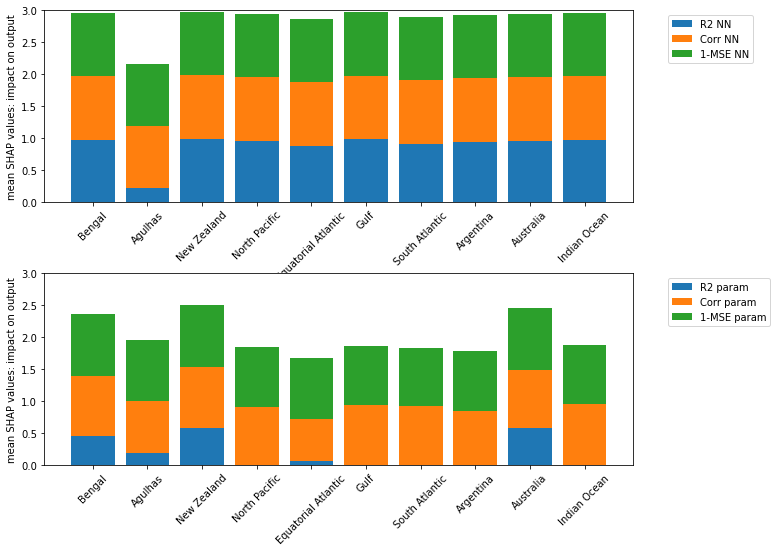

In [501]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
fig.tight_layout(pad=5.0)

plt.subplot(2,1,1)
plt.bar(label_list,r2_cnn,label='R2 NN')
plt.bar(label_list,corr_cnn,bottom=r2_cnn,label='Corr NN')
plt.bar(label_list,1-mse_cnn,bottom=r2_cnn+corr_cnn,label='1-MSE NN')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('mean SHAP values: impact on output')
plt.ylim([0,3])

plt.subplot(2,1,2)
plt.bar(label_list,r2_param,label='R2 param')
plt.bar(label_list,corr_param,bottom=r2_param,label='Corr param')
plt.bar(label_list,1-mse_param,bottom=r2_param+corr_param,label='1-MSE param')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('mean SHAP values: impact on output')
plt.ylim([0,3])

plt.savefig('./figures/fcnn/r2_corr_mse')
